


## Analysing Kickstarter Data


In this notebook I will be exploring data from Kickstarter crowdsourcing platform. I will be trying to answer the questions mentioned in my blog post.

>**Note:**  This notebook requires python 3.7+.

## Understatnding of the Bussiness

Kickstarter is plaform in which a person or organization could create a project and set a fund goal for that project. After that, investor's, called backers, would invest and support that project for a certain award. Kickstarter has three main guideline that project creators need to follow. The guidelines are meant to reinforce that individuals are backing projects and not ordering products. Projects can be categorized into one of 13 categories and 36 subcategories.


## Explore and Understand the Data
The code below aims to explore and understatnd the data that we are working with.

In [3]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import visuals as vs
from datetime import datetime



# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
df = pd.read_csv("KS2018.csv")

# Success - Display the first 5 records
display(df.head(n=2))


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00


In [4]:
print ("The count of the uniques values in each column are")
for col in df:
    print(col + " = " + str(df[col].unique().size))

The count of the uniques values in each column are
ID = 378661
name = 375765
category = 159
main_category = 15
currency = 14
deadline = 3164
goal = 8353
launched = 378089
pledged = 62130
state = 6
backers = 3963
country = 23
usd pledged = 95456
usd_pledged_real = 106065
usd_goal_real = 50339


### Understand the columns
 each of the coulmns in the data set has a unique meaning:

*   ID: Unique ID for each project
*   Name: Name of the project
*    Category: The subcategory of project
* Main Category: The main category of the project
* Currency: The currency of the set goal
* Deadline: The deadline date for 
* Goal: The amount of money that a creator needs to complete their project
* Launched: The date the project was launched
* Pledged: The amount of money people pledged to this project 
* State: The state of the project can be one of either
  - Failed
  - Canceled
  - Successful
  - Live
  - Undefined
  - Suspended
* Backers: Number of people of who pledged money to the project
* Country: The country where the project is created
* USD pledged: The amount of money pledged converted to USD by Kickstarter conversions
* USD pledged real: The amount of money pledged converted to USD by 3rd party tool.
* USD goal real: The amount of money the creator needs converted to USD by 3rd party tool.

## Prepare the Data

### Remove unnecessary columns

The first step in preparing our data is dropping the columns that are not needed.

The following columns will be dropped as they are unique to the project and will skew our analysis when trying to predict the success or failure of the project
* ID
* Name
* Goal
* Pledged
* USD Pledged
* USD Pledged Real
* USD Goal Real
* Backers

In [5]:

features_raw = df.drop('ID', axis = 1)
features_raw.drop('name', axis = 1, inplace=True)
features_raw.drop('goal', axis = 1, inplace=True)
features_raw.drop('pledged', axis = 1, inplace=True)
features_raw.drop('backers', axis = 1, inplace=True)
features_raw.drop('usd pledged', axis = 1, inplace=True)
features_raw.drop('usd_pledged_real', axis = 1, inplace=True)
features_raw.drop('usd_goal_real', axis = 1, inplace=True)


features_raw.head(n=2)

,category,main_category,currency,deadline,launched,state,country
0,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB
1,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US


### Remove unnecessary rows

Projects can have one of six states:
  - Failed
  - Canceled
  - Successful
  - Live
  - Undefined
  - Suspended
  
  We will remove projects with Live or Undefined state as we cannot conclude anything about the success or failure of the project.
  
  As for the Failed, Cacelled, or Suspended projects we will consider them all failures.
  Only the Successful status will be considered as a successful project.



In [6]:
features_raw.drop( features_raw[ features_raw['state'] == 'live' ].index , inplace=True)
features_raw.drop( features_raw[ features_raw['state'] == 'undefined' ].index , inplace=True)

In [7]:
features_raw.shape

(372300, 7)

After dorpping all of the unnecessary columns and rows we are left with 7 columns and 372300 rows.

### Compute campaign length
Additionally we would like to compute the number of days between the begining of the project till the end.
However, fisrt we need to split the launch column into date and time.

In [8]:
features_raw[['lDate','lTime']] = features_raw.launched.str.split(expand=True,)

features_raw.head(n=2)


,category,main_category,currency,deadline,launched,state,country,lDate,lTime
0,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB,2015-08-11,12:12:28
1,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US,2017-09-02,04:43:57


In [9]:
features_raw.drop('launched', axis = 1, inplace=True)

Next we would like to compute the length of the campaign in days. 

In [10]:
features_raw['deadline'] = pd.to_datetime(features_raw['deadline'])
features_raw['lDate'] = pd.to_datetime(features_raw['lDate'])
features_raw['days'] = (features_raw['deadline'] - features_raw['lDate']).dt.days

features_raw.head(n=2)

,category,main_category,currency,deadline,state,country,lDate,lTime,days
0,Poetry,Publishing,GBP,2015-10-09,failed,GB,2015-08-11,12:12:28,59
1,Narrative Film,Film & Video,USD,2017-11-01,failed,US,2017-09-02,04:43:57,60


In [11]:
features_raw.drop('deadline', axis = 1, inplace=True)
features_raw.drop('lDate', axis = 1, inplace=True)
features_raw.drop('lTime', axis = 1, inplace=True)

### Normalize Numerical Features
We would like to normalize each numerical feature. In this project we only have one numerical feature (days) 
We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [12]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['days']

features_log_minmax_transform = pd.DataFrame(data = features_raw)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_raw[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 2))

,category,main_category,currency,state,country,days
0,Poetry,Publishing,GBP,failed,GB,0.003465
1,Narrative Film,Film & Video,USD,failed,US,0.003525


### Encode all categorical variables

We would like to encode all categorical variables using one-hot encoding scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature.

We will use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 

In [13]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform,columns=['category','main_category', 'currency', 'country'])

encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))


213 total features after one-hot encoding.


### Extract and Encode the Data Labels
Below we will extract the state which is our data label to a new dataframe. Then we will encode the successful state to 1 and other states to 0.

In [14]:

state = features_final['state']
features_final.drop('state',axis=1,inplace=True)

state = state.apply(lambda x: 1 if x == 'successful' else 0 )

state.head(n=2)

0    0
1    0
Name: state, dtype: int64

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.


In [15]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final,
                                                    state,
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 297840 samples.
Testing set has 74460 samples.


----
## Modling and Evaluating Model Performance
In this section, we will investigate two differnt supervised learners and evaluate their performance in predict the success or failure of a project. Moreover, we will evaluate the model's performance using 1% of the data, 10% of the data, 100% of the data.


### Two supervised learners
1. Decision Trees 
 + Strenghths: Minimal data preparation, and suitable for both categorical and numerical data!
 + Weaknesses: Over-complex trees do not generalise the data well, and learning an optimal decision tree is known to be NP-complete!
 + Why this Model: Descision Trees tend to perform well at binary classifiication.
 + [`Reference1`](https://scikit-learn.org/stable/modules/tree.html)
 + [`Reference2`](https%3A%2F%2Fbooksite.elsevier.com%2F9780124438804%2Fleondes_expert_vol1_ch3.pdf&usg=AOvVaw2I_dUwcITKT-i_yi8iChLC)
  
 
 
2. Random Forest (Ensemble Method)
 + Strenghths: Random Forests and Ensemble Methods generalize better that single esitmators (e.g. Decsion Trees)
 + Weaknesses: Random Forests might overfit if the data is noisy.
 + Why this Model: Random Forests is expected to overcome the overfitting limitation of decsion trees (our first model)
 + [`Reference1`](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)
 + [`Reference2`](http://blog.citizennet.com/blog/2012/11/10/random-forests-ensembles-and-performance-metrics)
 + [`Reference3`](https%3A%2F%2Fwww.ncbi.nlm.nih.gov%2Fpmc%2Farticles%2FPMC4062420%2F&usg=AOvVaw1VQtVvD6EmyvewEpSR1TMI)
 

In [16]:

TP = np.sum(state)
FP = state.count() - TP
FN = TN = 0
Tot = len(state)
# TODO: Calculate accuracy, precision and recall
accuracy = TP/Tot
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
B2 = 0.5*0.5
fscore = ((1 + B2) * (precision*recall) / ((B2*precision) + recall))

In [17]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

DecisionTreeClassifier trained on 2978 samples.
DecisionTreeClassifier trained on 29784 samples.
DecisionTreeClassifier trained on 297840 samples.
RandomForestClassifier trained on 2978 samples.
RandomForestClassifier trained on 29784 samples.
RandomForestClassifier trained on 297840 samples.
AdaBoostClassifier trained on 2978 samples.
AdaBoostClassifier trained on 29784 samples.
AdaBoostClassifier trained on 297840 samples.


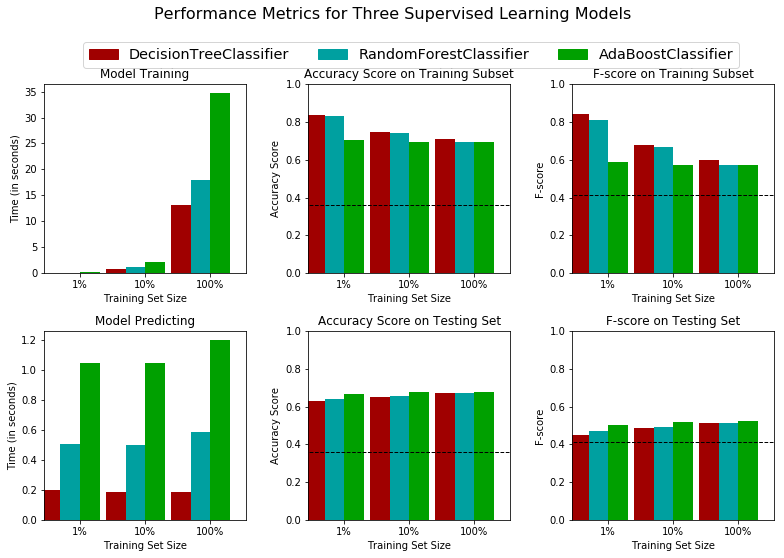

In [18]:
# Import the  supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


# Initialize the models
clf_A = DecisionTreeClassifier(random_state = 1)
clf_B = RandomForestClassifier(random_state = 1)
clf_C = AdaBoostClassifier(random_state = 1)

# Calculate the number of samples for 1%, 10%, and 100% of the training data

samples_100 = len(y_train)
samples_10 = int(len(y_train)*0.1)
samples_1 = int(len(y_train)*0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

### Implementation: Model Tuning
We fine tune the best model `AdaBoost`using grid search 
 [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) 

In [19]:
# Import 'GridSearchCV', 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = AdaBoostClassifier(random_state = 1)


parameters = { "n_estimators"      : [50,75]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer )

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.6789
F-score on testing data: 0.5227

Optimized Model
------
Final accuracy score on the testing data: 0.6795
Final F-score on the testing data: 0.5256


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |  0.6789    |     0.6795            |
| F-score        |     0.5227              |   0.5256       |


----
## Feature Importance

An important task when performing supervised learning on a dataset  is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether a project will succeed or not.

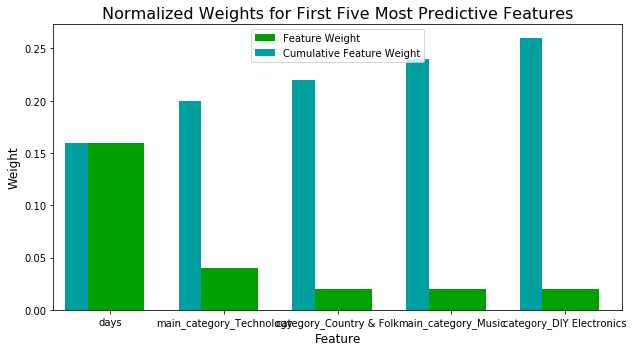

In [20]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier(random_state = 1)
model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

In [21]:
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:5]]

print(columns)

['days' 'main_category_Technology' 'category_Country & Folk'
 'main_category_Music' 'category_DIY Electronics']


In [ ]:
!!jupyter nbconvert *.ipynb